# Examples with Mean_Flux_Regulation

In [12]:
%matplotlib notebook

In [56]:
# imports
import numpy as np
from matplotlib import pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord

from linetools.spectralline import AbsLine
from linetools.analysis import voigt

from pyigm.fN import mockforest as pyimock
from pyigm.fN.fnmodel import FNModel
from pyigm.igm import mfr as py_mfr

## Build a Lya forest

In [9]:
fN_model = FNModel.default_model()

Using P14 spline values to generate a default model
Loading: /Users/xavier/local/Python/pyigm/pyigm/data/fN/fN_spline_z24.fits.gz


In [3]:
# Quasar
zem = 2.5
# Spectral
s2n = 10.
sampling = 2.
R = 2000.

In [17]:
# Resultant wavelength array (using constant dwv instead of constant dv)
disp = 4000/R/sampling # Angstrom
wave = np.arange(3600., 1300*(1+zem), disp)*u.AA

In [20]:
norm_spec, HI_comps, _ = pyimock.mk_mock(wave, zem, fN_model, s2n=s2n, fwhm=sampling, add_conti=False)

Using a Flat LCDM cosmology: h=0.7, Om=0.3


<IPython.core.display.Javascript object>


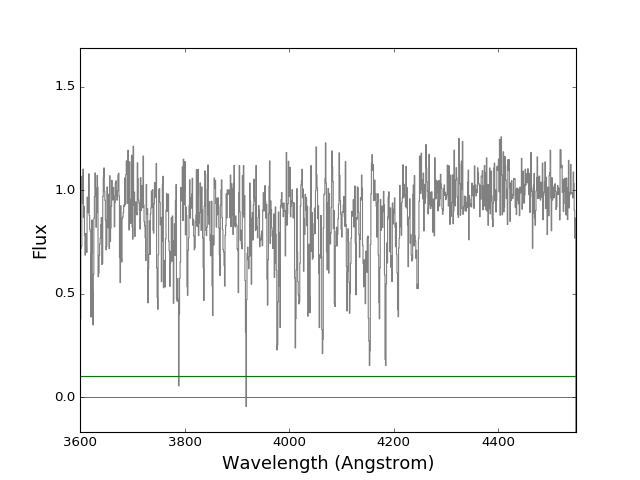

In [21]:
norm_spec.plot()

## Tilt it

<IPython.core.display.Javascript object>


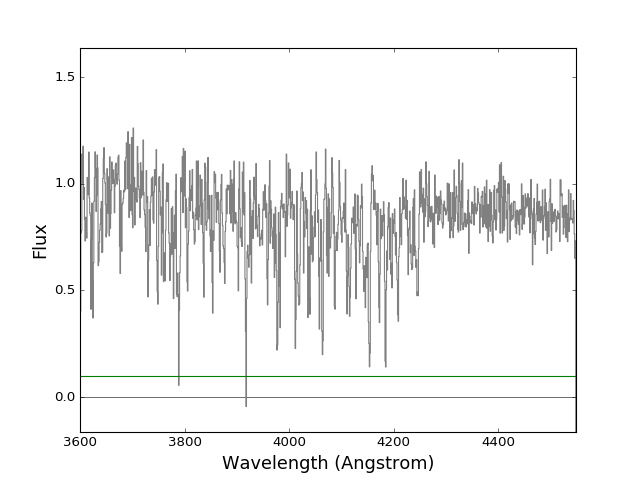

In [24]:
flambda = (norm_spec.wavelength.value/3850.)**(-1)
flux_spec = norm_spec.copy()
flux_spec.flux = norm_spec.flux * flambda
flux_spec.plot()

## Fit it

In [42]:
reload(py_mfr)
new_flux, parm = py_mfr.fit_forest(flux_spec.wavelength.value, flux_spec.flux.value, flux_spec.sig.value, zem)
parm

<mflux_tauevo(p0=0.9760194990734268, p1=-1.6508431495185911, zqso=2.5, lamb_piv=1113.0)>

### Plot

In [32]:
lambda_r = flux_spec.wavelength.value / (1+zem)
new_conti = py_mfr.mfluxcorr(lambda_r,parm.p0.value, parm.p1.value,lamb_piv=parm.lamb_piv.value)

In [60]:
def show_fit(flux_spec, conti, another_conti=None):
    plt.clf()
    ax = plt.gca()
    ax.plot(flux_spec.wavelength, flux_spec.flux, 'k')
    ax.plot(flux_spec.wavelength, conti, 'r')
    if another_conti is not None:
        ax.plot(flux_spec.wavelength, another_conti, 'b')
    #
    ax.set_ylim(-0.1, 1.4)
    plt.show()

<IPython.core.display.Javascript object>


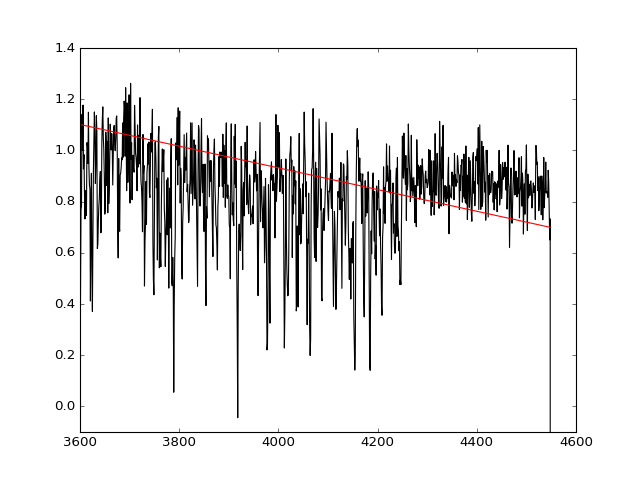

In [40]:
show_fit(flux_spec, new_conti)

## Mask a region

In [36]:
mask = [[4000., 4015.]]

In [43]:
_, parm2 = py_mfr.fit_forest(flux_spec.wavelength.value, flux_spec.flux.value, flux_spec.sig.value, zem,
                                  user_mask=mask)
parm2

<mflux_tauevo(p0=0.9750752720125853, p1=-1.6687417165142182, zqso=2.5, lamb_piv=1113.0)>

## Add a DLA, avoid the DLA

### Make a DLA

In [48]:
z_dla = 4000./1215.67 - 1.
dla = AbsLine('HI 1215', z=z_dla)
dla.attrib['N'] = 10**21 / u.cm**2
dla.attrib['b'] = 30. * u.km/u.s

In [50]:
dla_voigt = voigt.voigt_from_abslines(flux_spec.wavelength, dla, fwhm=3.)

/Users/xavier/local/Python/linetools/linetools/analysis/voigt.py:182: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/xavier/local/Python/linetools/linetools/analysis/voigt.py:183: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')


### Insert

<IPython.core.display.Javascript object>


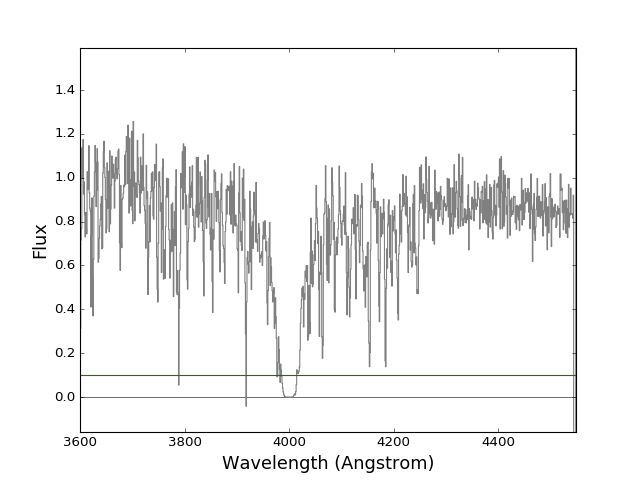

In [51]:
dla_spec = flux_spec.copy()
dla_spec.flux = flux_spec.flux * dla_voigt.flux
dla_spec.plot()

### Create DLA table

In [54]:
dla_tbl = Table()
dla_tbl['RA'] = [123.45]
dla_tbl['DEC'] = 12.34
dla_tbl['z'] = z_dla

### Fit with DLAs

In [57]:
coord = SkyCoord(ra=dla_tbl['RA'][0], dec=dla_tbl['DEC'][0], unit='deg')

In [58]:
reload(py_mfr)
_, parm3 = py_mfr.fit_forest(dla_spec.wavelength.value, dla_spec.flux.value, dla_spec.sig.value, zem,
                                  mask_dlas=dla_tbl, coord=coord)

In [59]:
parm3

<mflux_tauevo(p0=0.958680540449373, p1=-1.9658730579503034, zqso=2.5, lamb_piv=1113.0)>

<IPython.core.display.Javascript object>


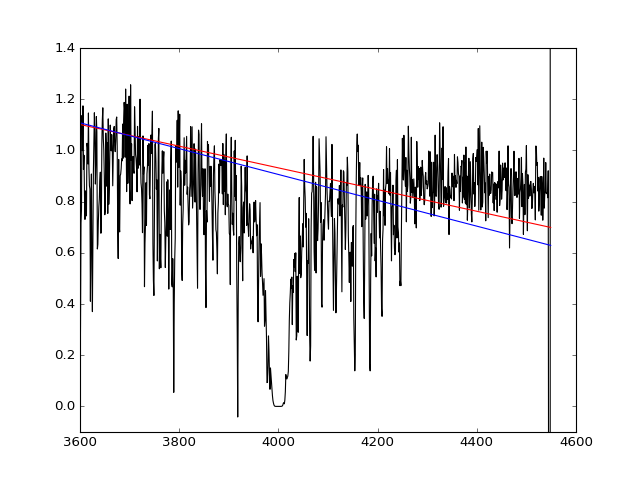

In [61]:
dla_conti = py_mfr.mfluxcorr(lambda_r,parm3.p0.value, parm3.p1.value,lamb_piv=parm3.lamb_piv.value)
show_fit(dla_spec, new_conti, another_conti=dla_conti)